**Pergunta-Guia: O Brasil é um país desigual?**



> Projeto do primeiro módulo da disciplina de estatística para ciência de dados. Composto pela equipe: Ana Caroline, Carlos Eduardo, Claudio Cruz, Julio Sousa e Maria Eduarda.
Nesse projeto analisamos e cruzamos os dados dos estados e munícipios do Nordeste.



# Importação e cruzamento dos dados

In [245]:
import pandas as pd

!gdown --id 1GQVxYHY9ouZvh_Jkbzt3sjnWHslxGqnX
!gdown --id 1OLg85S7vAr4MQomc_wcaQhRo6SLciSu0
!gdown --id 1G3Ll5LsIhsvpodjnKg6JE0KXbc_D-BSP


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/gdown/cli.py:142: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1GQVxYHY9ouZvh_Jkbzt3sjnWHslxGqnX
To: /Users/dudanobre/Documents/POS/sidra-nordeste/tabela5938_2020.csv.xz
100%|█████████████████████████████████████████| 142k/142k [00:00<00:00, 166MB/s]
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/gdown/cli.py:142: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1OLg85S7vAr4MQomc_wcaQhRo6SLciSu0
To: /Users/dudanobre/Documents/POS/sidra-nordeste/tabela6579_2020.csv.xz
100%|███████████████████████████████████████| 55.3k/55.3k [00:00<00:00, 702

In [246]:
df_pib = pd.read_csv("tabela5938_2020.csv.xz")
df_pop = pd.read_csv("tabela6579_2020.csv.xz")
df_dtb = pd.read_csv("RELATORIO_DTB_BRASIL_MUNICIPIO.csv")

In [247]:
df_pib

,Cód.,Município,PIB (Mil Reais),Impostos (Mil Reais),VA da agropecuária (Mil Reais),VA da indústria (Mil Reais),VA dos serviços (Mil Reais),VA da administração pública (Mil Reais)
0,1100015,Alta Floresta D'Oeste (RO),570272.0,35109.0,203394.0,20716.0,150192.0,160860.0
1,1100023,Ariquemes (RO),2818049.0,295656.0,199723.0,404752.0,1207405.0,710513.0
2,1100031,Cabixi (RO),167190.0,7237.0,81177.0,5438.0,28667.0,44671.0
3,1100049,Cacoal (RO),2519353.0,274451.0,236215.0,275537.0,1157344.0,575806.0
4,1100056,Cerejeiras (RO),600670.0,89923.0,94758.0,23582.0,276755.0,115652.0
...,...,...,...,...,...,...,...,...
5565,5222005,Vianópolis (GO),587313.0,50678.0,237994.0,31362.0,198625.0,68654.0
5566,5222054,Vicentinópolis (GO),418557.0,33375.0,158818.0,75909.0,102478.0,47977.0
5567,5222203,Vila Boa (GO),121887.0,7569.0,28358.0,22837.0,29547.0,33577.0
5568,5222302,Vila Propício (GO),218473.0,8738.0,115114.0,26940.0,34812.0,32870.0


In [248]:
df_pop

,Cód.,Município,População (Pessoas)
0,1100015,Alta Floresta D'Oeste (RO),22728.0
1,1100023,Ariquemes (RO),109523.0
2,1100031,Cabixi (RO),5188.0
3,1100049,Cacoal (RO),85893.0
4,1100056,Cerejeiras (RO),16204.0
...,...,...,...
5565,5222005,Vianópolis (GO),13977.0
5566,5222054,Vicentinópolis (GO),8873.0
5567,5222203,Vila Boa (GO),6312.0
5568,5222302,Vila Propício (GO),5882.0


In [249]:
df_dtb

,UF,Nome_UF,Região Geográfica Intermediária,Nome Região Geográfica Intermediária,Região Geográfica Imediata,Nome Região Geográfica Imediata,Mesorregião Geográfica,Nome_Mesorregião,Microrregião Geográfica,Nome_Microrregião,Município,Código Município Completo,Nome_Município
0,11,Rondônia,1102,Ji-Paraná,110005,Cacoal,2,Leste Rondoniense,6,Cacoal,15,1100015,Alta Floresta D'Oeste
1,11,Rondônia,1102,Ji-Paraná,110005,Cacoal,2,Leste Rondoniense,6,Cacoal,379,1100379,Alto Alegre dos Parecis
2,11,Rondônia,1101,Porto Velho,110002,Ariquemes,2,Leste Rondoniense,3,Ariquemes,403,1100403,Alto Paraíso
3,11,Rondônia,1102,Ji-Paraná,110004,Ji-Paraná,2,Leste Rondoniense,5,Alvorada D'Oeste,346,1100346,Alvorada D'Oeste
4,11,Rondônia,1101,Porto Velho,110002,Ariquemes,2,Leste Rondoniense,3,Ariquemes,23,1100023,Ariquemes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,52,Goiás,5201,Goiânia,520002,Anápolis,5,Sul Goiano,16,Pires do Rio,22005,5222005,Vianópolis
5566,52,Goiás,5202,Itumbiara,520009,Piracanjuba,5,Sul Goiano,15,Meia Ponte,22054,5222054,Vicentinópolis
5567,52,Goiás,5206,Luziânia - Águas Lindas de Goiás,520022,Flores de Goiás,4,Leste Goiano,12,Entorno de Brasília,22203,5222203,Vila Boa
5568,52,Goiás,5205,Porangatu - Uruaçu,520018,Ceres - Rialma - Goianésia,4,Leste Goiano,12,Entorno de Brasília,22302,5222302,Vila Propício


In [250]:
df_aux1 = pd.merge(df_pib,df_pop,how='outer',left_on='Cód.',right_on='Cód.')
df_aux1 = df_aux1.drop(columns=['Município_y'])
df_aux1

,Cód.,Município_x,PIB (Mil Reais),Impostos (Mil Reais),VA da agropecuária (Mil Reais),VA da indústria (Mil Reais),VA dos serviços (Mil Reais),VA da administração pública (Mil Reais),População (Pessoas)
0,1100015,Alta Floresta D'Oeste (RO),570272.0,35109.0,203394.0,20716.0,150192.0,160860.0,22728.0
1,1100023,Ariquemes (RO),2818049.0,295656.0,199723.0,404752.0,1207405.0,710513.0,109523.0
2,1100031,Cabixi (RO),167190.0,7237.0,81177.0,5438.0,28667.0,44671.0,5188.0
3,1100049,Cacoal (RO),2519353.0,274451.0,236215.0,275537.0,1157344.0,575806.0,85893.0
4,1100056,Cerejeiras (RO),600670.0,89923.0,94758.0,23582.0,276755.0,115652.0,16204.0
...,...,...,...,...,...,...,...,...,...
5565,5222005,Vianópolis (GO),587313.0,50678.0,237994.0,31362.0,198625.0,68654.0,13977.0
5566,5222054,Vicentinópolis (GO),418557.0,33375.0,158818.0,75909.0,102478.0,47977.0,8873.0
5567,5222203,Vila Boa (GO),121887.0,7569.0,28358.0,22837.0,29547.0,33577.0,6312.0
5568,5222302,Vila Propício (GO),218473.0,8738.0,115114.0,26940.0,34812.0,32870.0,5882.0


In [251]:
df_geral = pd.merge(df_aux1,df_dtb,how='left',left_on='Cód.',right_on='Código Município Completo')
df_geral

,Cód.,Município_x,PIB (Mil Reais),Impostos (Mil Reais),VA da agropecuária (Mil Reais),VA da indústria (Mil Reais),VA dos serviços (Mil Reais),VA da administração pública (Mil Reais),População (Pessoas),UF,...,Nome Região Geográfica Intermediária,Região Geográfica Imediata,Nome Região Geográfica Imediata,Mesorregião Geográfica,Nome_Mesorregião,Microrregião Geográfica,Nome_Microrregião,Município,Código Município Completo,Nome_Município
0,1100015,Alta Floresta D'Oeste (RO),570272.0,35109.0,203394.0,20716.0,150192.0,160860.0,22728.0,11,...,Ji-Paraná,110005,Cacoal,2,Leste Rondoniense,6,Cacoal,15,1100015,Alta Floresta D'Oeste
1,1100023,Ariquemes (RO),2818049.0,295656.0,199723.0,404752.0,1207405.0,710513.0,109523.0,11,...,Porto Velho,110002,Ariquemes,2,Leste Rondoniense,3,Ariquemes,23,1100023,Ariquemes
2,1100031,Cabixi (RO),167190.0,7237.0,81177.0,5438.0,28667.0,44671.0,5188.0,11,...,Ji-Paraná,110006,Vilhena,2,Leste Rondoniense,8,Colorado do Oeste,31,1100031,Cabixi
3,1100049,Cacoal (RO),2519353.0,274451.0,236215.0,275537.0,1157344.0,575806.0,85893.0,11,...,Ji-Paraná,110005,Cacoal,2,Leste Rondoniense,6,Cacoal,49,1100049,Cacoal
4,1100056,Cerejeiras (RO),600670.0,89923.0,94758.0,23582.0,276755.0,115652.0,16204.0,11,...,Ji-Paraná,110006,Vilhena,2,Leste Rondoniense,8,Colorado do Oeste,56,1100056,Cerejeiras
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,5222005,Vianópolis (GO),587313.0,50678.0,237994.0,31362.0,198625.0,68654.0,13977.0,52,...,Goiânia,520002,Anápolis,5,Sul Goiano,16,Pires do Rio,22005,5222005,Vianópolis
5566,5222054,Vicentinópolis (GO),418557.0,33375.0,158818.0,75909.0,102478.0,47977.0,8873.0,52,...,Itumbiara,520009,Piracanjuba,5,Sul Goiano,15,Meia Ponte,22054,5222054,Vicentinópolis
5567,5222203,Vila Boa (GO),121887.0,7569.0,28358.0,22837.0,29547.0,33577.0,6312.0,52,...,Luziânia - Águas Lindas de Goiás,520022,Flores de Goiás,4,Leste Goiano,12,Entorno de Brasília,22203,5222203,Vila Boa
5568,5222302,Vila Propício (GO),218473.0,8738.0,115114.0,26940.0,34812.0,32870.0,5882.0,52,...,Porangatu - Uruaçu,520018,Ceres - Rialma - Goianésia,4,Leste Goiano,12,Entorno de Brasília,22302,5222302,Vila Propício


In [252]:
df_geral.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Cód.                                     5570 non-null   int64  
 1   Município_x                              5570 non-null   object 
 2   PIB (Mil Reais)                          5570 non-null   float64
 3   Impostos (Mil Reais)                     5570 non-null   float64
 4   VA da agropecuária (Mil Reais)           5570 non-null   float64
 5   VA da indústria (Mil Reais)              5570 non-null   float64
 6   VA dos serviços (Mil Reais)              5570 non-null   float64
 7   VA da administração pública (Mil Reais)  5570 non-null   float64
 8   População (Pessoas)                      5570 non-null   float64
 9   UF                                       5570 non-null   int64  
 10  Nome_UF                                  5570 no

In [253]:
uf_ne=['Alagoas','Bahia','Ceará','Maranhão','Paraíba','Pernambuco','Piauí','Rio Grande do Norte','Sergipe']
df_nordeste = df_geral[df_geral['Nome_UF'].isin(uf_ne)]

df_nordeste.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1794 entries, 450 to 2243
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Cód.                                     1794 non-null   int64  
 1   Município_x                              1794 non-null   object 
 2   PIB (Mil Reais)                          1794 non-null   float64
 3   Impostos (Mil Reais)                     1794 non-null   float64
 4   VA da agropecuária (Mil Reais)           1794 non-null   float64
 5   VA da indústria (Mil Reais)              1794 non-null   float64
 6   VA dos serviços (Mil Reais)              1794 non-null   float64
 7   VA da administração pública (Mil Reais)  1794 non-null   float64
 8   População (Pessoas)                      1794 non-null   float64
 9   UF                                       1794 non-null   int64  
 10  Nome_UF                                  1794 non-n

In [254]:
df_nordeste = df_nordeste.drop(columns=['Código Município Completo'])

# Cálculo de variáveis auxiliares

# Aplicação de medidas estatísticas

**Cálculo do PIB per capita dos municípios do Nordeste em reais**

In [255]:
df_nordeste['PIB per capita'] = (df_nordeste['PIB (Mil Reais)'] * 1000) / df_nordeste['População (Pessoas)']

df_nordeste.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1794 entries, 450 to 2243
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Cód.                                     1794 non-null   int64  
 1   Município_x                              1794 non-null   object 
 2   PIB (Mil Reais)                          1794 non-null   float64
 3   Impostos (Mil Reais)                     1794 non-null   float64
 4   VA da agropecuária (Mil Reais)           1794 non-null   float64
 5   VA da indústria (Mil Reais)              1794 non-null   float64
 6   VA dos serviços (Mil Reais)              1794 non-null   float64
 7   VA da administração pública (Mil Reais)  1794 non-null   float64
 8   População (Pessoas)                      1794 non-null   float64
 9   UF                                       1794 non-null   int64  
 10  Nome_UF                                  1794 non-n

In [256]:
df_nordeste_teste = df_nordeste.groupby(['Nome_UF'])['PIB per capita']

In [265]:
df_nordeste_teste = df_nordeste.groupby(['Nome_UF'])['PIB per capita'].describe()
df_nordeste_teste['coef_variacao'] = ((df_nordeste_teste['std']/df_nordeste_teste['mean']) *100).round(2)
df_nordeste_teste = df_nordeste_teste.sort_values(by='coef_variacao',ascending=False)
df_nordeste_teste

,count,mean,std,min,25%,50%,75%,max,coef_variacao
Nome_UF,,,,,,,,,
Maranhão,217.0,12469.984085,22230.900674,4924.029824,6985.610552,8022.925095,10454.239092,260020.624563,178.28
Bahia,417.0,14718.686529,19782.901746,6217.444797,8621.412037,10636.552201,13704.371851,296357.510250,134.41
Rio Grande do Norte,167.0,17312.085158,19136.145405,8069.878345,10351.992622,12115.608108,16190.413387,153580.787633,110.54
Pernambuco,185.0,13597.080376,13406.616301,6517.159309,8569.627836,10605.875153,13537.371103,139391.956506,98.60
Piauí,224.0,13484.865672,12936.916976,7026.198652,8827.227429,9904.479783,11604.744722,105367.320709,95.94
Alagoas,102.0,16874.788528,14253.248997,6958.093673,10540.480132,13385.047324,18673.473587,129102.648077,84.46
Sergipe,75.0,16220.558406,11509.882723,9318.468702,11549.530207,13627.631157,16802.895309,103993.289915,70.96
Paraíba,223.0,11685.011823,7840.521714,7340.892330,8970.610615,10199.226306,11729.765515,111427.130329,67.10
Ceará,184.0,12504.510638,8043.999133,6695.223037,8673.445125,10444.428185,13215.399689,83473.122020,64.33


**Nota**: o Coeficiente de variação (CV) é a razão entre desvio padrão e média, expressa em %, e serve para comparar a variabilidade relativa, importante para entender desigualdade nesse contexto.

**Análise**: Os estados Coeficiente de variação mais alto têm desigualdade maior entre seus municípios. 
Sendo o top 5: Maranhão, Bahia, Rio Grande do Norte, Pernambuco e Piauí. 

In [258]:
estados_desiguais = ['Maranhão', 'Bahia', 'Rio Grande do Norte']
df_desiguais = df_nordeste[df_nordeste['Nome_UF'].isin(estados_desiguais)].sort_values(by='PIB per capita', ascending=False)

df_desiguais

,Cód.,Município_x,PIB (Mil Reais),Impostos (Mil Reais),VA da agropecuária (Mil Reais),VA da indústria (Mil Reais),VA dos serviços (Mil Reais),VA da administração pública (Mil Reais),População (Pessoas),UF,...,Nome Região Geográfica Intermediária,Região Geográfica Imediata,Nome Região Geográfica Imediata,Mesorregião Geográfica,Nome_Mesorregião,Microrregião Geográfica,Nome_Microrregião,Município,Nome_Município,PIB per capita
2183,2929206,São Francisco do Conde (BA),11926908.0,1701590.0,15880.0,7050260.0,2676570.0,482608.0,40245.0,29,...,Salvador,290001,Salvador,5,Metropolitana de Salvador,21,Salvador,29206,São Francisco do Conde,296357.510250
651,2112001,Tasso Fragoso (MA),2231497.0,40467.0,1802825.0,70205.0,270694.0,47307.0,8582.0,21,...,Imperatriz,210022,Balsas,5,Sul Maranhense,20,Gerais de Balsas,12001,Tasso Fragoso,260020.624563
619,2110302,Santo Antônio dos Lopes (MA),2389821.0,104162.0,14516.0,2093630.0,73080.0,104434.0,14522.0,21,...,Santa Inês - Bacabal,210012,Pedreiras,3,Centro Maranhense,10,Médio Mearim,10302,Santo Antônio dos Lopes,164565.555709
1201,2411601,São Bento do Norte (RN),417279.0,39469.0,13403.0,318404.0,21479.0,24524.0,2717.0,24,...,Natal,240005,João Câmara,2,Central Potiguar,8,Macau,11601,São Bento do Norte,153580.787633
1961,2911105,Formosa do Rio Preto (BA),3803358.0,108356.0,2852057.0,107700.0,599491.0,135755.0,25857.0,29,...,Barreiras,290018,Barreiras,1,Extremo Oeste Baiano,1,Barreiras,11105,Formosa do Rio Preto,147092.006033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,2105351,Itaipava do Grajaú (MA),88913.0,2478.0,12564.0,2351.0,16765.0,54755.0,16005.0,21,...,Imperatriz,210020,Barra do Corda,3,Centro Maranhense,11,Alto Mearim e Grajaú,5351,Itaipava do Grajaú,5555.326460
604,2109403,Primeira Cruz (MA),84003.0,1874.0,10555.0,2324.0,12785.0,56466.0,15431.0,21,...,São Luís,210006,Barreirinhas,1,Norte Maranhense,4,Lençóis Maranhenses,9403,Primeira Cruz,5443.781997
503,2103125,Central do Maranhão (MA),46940.0,2082.0,3947.0,1364.0,10577.0,28970.0,8740.0,21,...,São Luís,210008,Cururupu,1,Norte Maranhense,1,Litoral Ocidental Maranhense,3125,Central do Maranhão,5370.709382
618,2110278,Santo Amaro do Maranhão (MA),85793.0,2485.0,9348.0,2080.0,16065.0,55815.0,16034.0,21,...,São Luís,210006,Barreirinhas,1,Norte Maranhense,4,Lençóis Maranhenses,10278,Santo Amaro do Maranhão,5350.692279


In [259]:
import pandas as pd

# Estados mais desiguais
estados_desiguais = ['Maranhão', 'Bahia', 'Rio Grande do Norte']

# Lista para armazenar os resultados
resultados = []

for estado in estados_desiguais:
    # Filtra só o estado
    df_estado = df_nordeste[df_nordeste['Nome_UF'] == estado]
    
    # Calcula a média do estado
    media_estado = df_estado['PIB per capita'].mean()
    
    # Pega os top 5 municípios por PIB per capita
    top_municipios = df_estado.sort_values(by='PIB per capita', ascending=False).head(5)
    
    # Adiciona ao resultado
    for _, row in top_municipios.iterrows():
        resultados.append({
            'Estado': estado,
            'Município': row['Nome_Município'],
            'PIB per capita': row['PIB per capita'],
            'Média do estado': media_estado,
            'Acima da média (%)': round(((row['PIB per capita'] - media_estado) / media_estado) * 100, 2)
        })

# Converte para DataFrame
df_top = pd.DataFrame(resultados)

# Mostra o resultado ordenado por estado e PIB
df_top = df_top.sort_values(by=['Estado', 'PIB per capita'], ascending=[True, False])


In [260]:
df_uf_agrupado = df_nordeste.groupby('Nome_UF').sum(numeric_only=True).reset_index()
df_uf_agrupado['PIB per capita (UF)'] = (df_uf_agrupado['PIB (Mil Reais)'] * 1000) /df_uf_agrupado['População (Pessoas)']
df_uf_agrupado = df_uf_agrupado.drop(columns=['PIB per capita'])
df_uf_agrupado

,Nome_UF,Cód.,PIB (Mil Reais),Impostos (Mil Reais),VA da agropecuária (Mil Reais),VA da indústria (Mil Reais),VA dos serviços (Mil Reais),VA da administração pública (Mil Reais),População (Pessoas),UF,Região Geográfica Intermediária,Região Geográfica Imediata,Mesorregião Geográfica,Microrregião Geográfica,Município,PIB per capita (UF)
0,Alagoas,275887914,63202350.0,6060840.0,12622357.0,7391283.0,22733533.0,14394354.0,3351543.0,2754,275552,27540588,230,742,487914,18857.687340
1,Bahia,1216451757,305320808.0,37094023.0,28006929.0,59491636.0,122722522.0,58005675.0,14930634.0,12093,1211622,120936832,1946,7881,7151757,20449.286212
2,Ceará,424495156,166914529.0,20755740.0,9508983.0,25084345.0,75388197.0,36177271.0,9187103.0,4232,423807,42321680,636,2996,1295156,18168.352853
3,Maranhão,457104205,106915961.0,12287745.0,11572446.0,17379117.0,39180324.0,26496333.0,7114598.0,4557,456260,45572446,561,2169,1404205,15027.688283
4,Paraíba,559441029,70292036.0,7823994.0,2823162.0,10000791.0,29024388.0,20619685.0,4039277.0,5575,557996,55751537,489,2396,1941029,17402.133105
5,Pernambuco,482524668,193307324.0,28538217.0,8661857.0,34048336.0,79777758.0,42281151.0,9616621.0,4810,481374,48101710,531,1738,1524668,20101.376981
6,Piauí,494075355,56391259.0,5805001.0,5699080.0,7058007.0,20907299.0,16921886.0,3281480.0,4928,493461,49282058,610,1889,1275355,17184.702939
7,Rio Grande do Norte,402076977,71577110.0,7760854.0,3010582.0,11811278.0,29207942.0,19786458.0,3534165.0,4008,401127,40081080,365,1731,1276977,20252.905566
8,Sergipe,210294557,45409659.0,4721693.0,2583361.0,8906252.0,17160838.0,12037511.0,2318822.0,2100,210104,21000228,177,503,294557,19583.072353


In [261]:
df_uf_agrupado['% VA da agropecuária'] = ((df_uf_agrupado['VA da agropecuária (Mil Reais)']/df_uf_agrupado['PIB (Mil Reais)'])*100).round(2)
df_uf_agrupado['% VA da indústria'] = ((df_uf_agrupado['VA da indústria (Mil Reais)']/df_uf_agrupado['PIB (Mil Reais)'])*100).round(2)
df_uf_agrupado['% VA dos serviços'] = ((df_uf_agrupado['VA dos serviços (Mil Reais)']/df_uf_agrupado['PIB (Mil Reais)'])*100).round(2)
df_uf_agrupado['% VA da administração pública'] = ((df_uf_agrupado['VA da administração pública (Mil Reais)']/df_uf_agrupado['PIB (Mil Reais)'])*100).round(2)
df_uf_agrupado['% Impostos'] = ((df_uf_agrupado['Impostos (Mil Reais)']/df_uf_agrupado['PIB (Mil Reais)'])*100).round(2)

In [262]:
df_nordeste_teste = df_nordeste.groupby(['Nome_Município'])['PIB per capita'].describe()
df_nordeste_teste

,count,mean,std,min,25%,50%,75%,max
Nome_Município,,,,,,,,
Abaiara,1.0,9158.019067,NaN,9158.019067,9158.019067,9158.019067,9158.019067,9158.019067
Abaré,1.0,8479.677594,NaN,8479.677594,8479.677594,8479.677594,8479.677594,8479.677594
Abaíra,1.0,7734.213548,NaN,7734.213548,7734.213548,7734.213548,7734.213548,7734.213548
Abreu e Lima,1.0,18189.972694,NaN,18189.972694,18189.972694,18189.972694,18189.972694,18189.972694
Acajutiba,1.0,9048.857576,NaN,9048.857576,9048.857576,9048.857576,9048.857576,9048.857576
...,...,...,...,...,...,...,...,...
Água Fria,1.0,8400.399225,NaN,8400.399225,8400.399225,8400.399225,8400.399225,8400.399225
Água Nova,1.0,10297.066015,NaN,10297.066015,10297.066015,10297.066015,10297.066015,10297.066015
Água Preta,1.0,6728.898118,NaN,6728.898118,6728.898118,6728.898118,6728.898118,6728.898118


**Medidas de tendência central e dispersão PIB per capita**

# Gráficos

/var/folders/gw/38t0m3710p57vxqjw00sb8q00000gn/T/ipykernel_92906/2942720834.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='coef_variacao', y='Nome_UF', data=df_cv, palette='viridis')


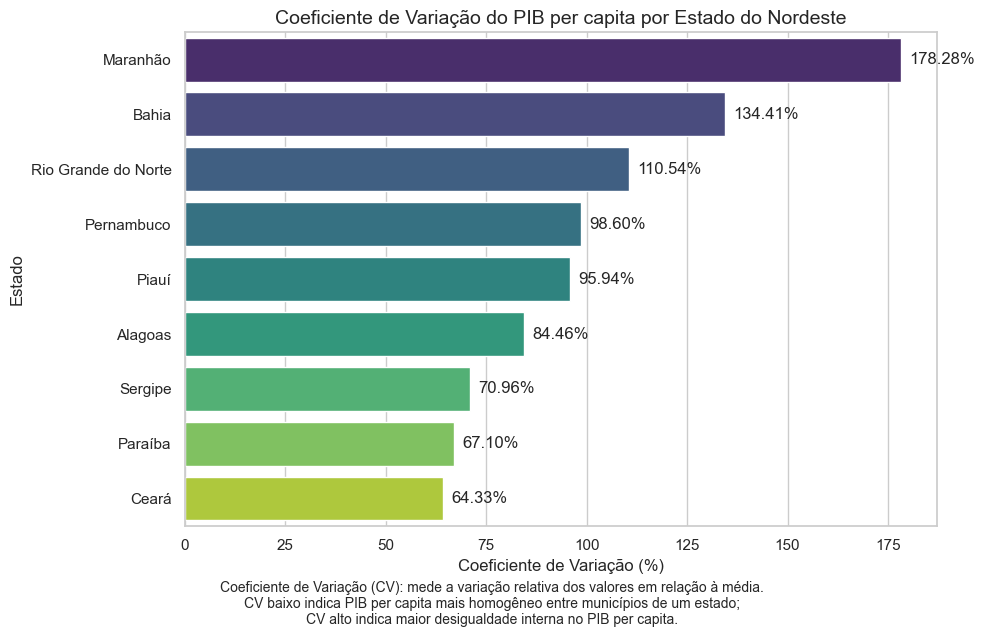

In [270]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_cv = pd.DataFrame(df_nordeste_teste['coef_variacao'])
df_cv = df_cv.reset_index()

sns.set_theme(style='whitegrid')

plt.figure(figsize=(10,6))
barplot = sns.barplot(x='coef_variacao', y='Nome_UF', data=df_cv, palette='viridis')

plt.title('Coeficiente de Variação do PIB per capita por Estado do Nordeste', fontsize=14)
plt.xlabel('Coeficiente de Variação (%)', fontsize=12)
plt.ylabel('Estado', fontsize=12)

for index, value in enumerate(df_cv['coef_variacao']):
    plt.text(value + 2, index, f'{value:.2f}%', va='center')

# Adiciona legenda explicativa embaixo do gráfico
plt.figtext(0.5, -0.05, 
            "Coeficiente de Variação (CV): mede a variação relativa dos valores em relação à média.\n"
            "CV baixo indica PIB per capita mais homogêneo entre municípios de um estado;\n"
            "CV alto indica maior desigualdade interna no PIB per capita.", 
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()


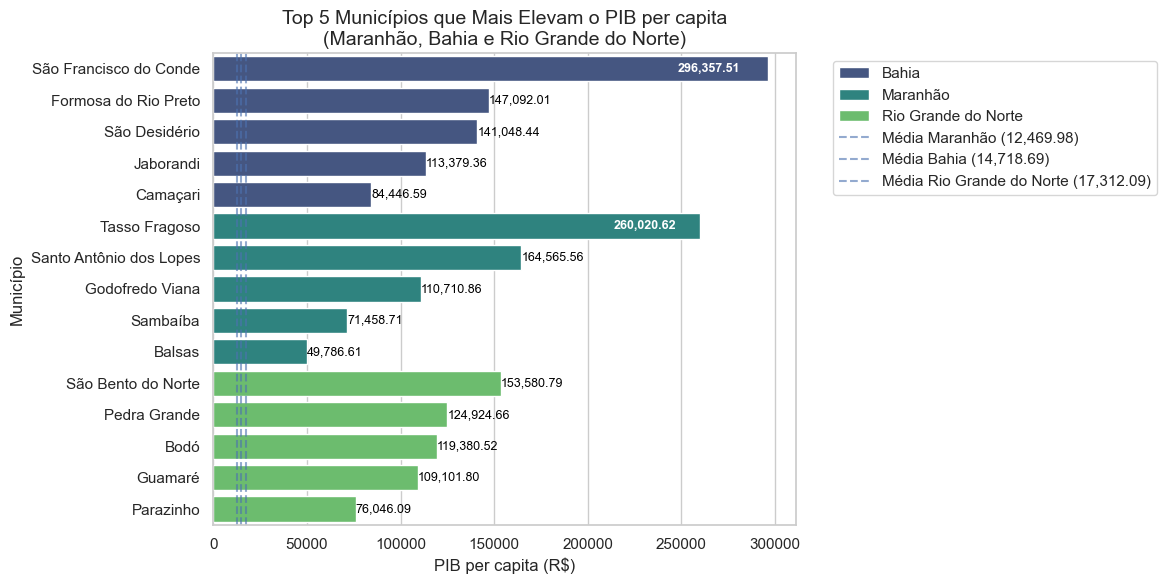

In [271]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    x='PIB per capita', 
    y='Município', 
    hue='Estado', 
    data=df_top, 
    palette='viridis'
)

# Adicionar valores nas barras
for p in barplot.patches:
    valor = p.get_width()
    if valor > 0:
        if valor > df_top['PIB per capita'].max() * 0.85:
            barplot.annotate(
                f'{valor:,.2f}',
                (valor - (valor * 0.05), p.get_y() + p.get_height() / 2),
                ha='right', va='center',
                color='white', fontsize=9, weight='bold'
            )
        else:
            barplot.annotate(
                f'{valor:,.2f}',
                (valor, p.get_y() + p.get_height() / 2),
                ha='left', va='center',
                color='black', fontsize=9
            )

# Linha de média para cada estado + valor na legenda
for estado in estados_desiguais:
    media = df_top[df_top['Estado'] == estado]['Média do estado'].iloc[0]
    plt.axvline(
        media, linestyle='--', 
        label=f'Média {estado} ({media:,.2f})',  # 👈 adiciona o valor no label
        alpha=0.6
    )

# Título e eixos
plt.title('Top 5 Municípios que Mais Elevam o PIB per capita\n(Maranhão, Bahia e Rio Grande do Norte)', fontsize=14)
plt.xlabel('PIB per capita (R$)', fontsize=12)
plt.ylabel('Município', fontsize=12)

# Evita legendas duplicadas
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


```
O gráfico acima mostra os munícipios que elevam o PIB per capita dos 3 estados mais desiguais do nordeste. 
Bahia: São Francisco do Conde lidera isoladamente, com quase R$ 300 mil por habitante, puxado pela refinaria de petróleo.

Maranhão: Tasso Fragoso e Balsas se destacam pelo agronegócio de soja.

Rio Grande do Norte: São Bento do Norte tem alta participação energética.
``` 

In [272]:
#estado
df_ordenado = df_uf_agrupado.sort_values(by='PIB per capita (UF)', ascending=False)
top3 = df_ordenado.head(3)
top3

,Nome_UF,Cód.,PIB (Mil Reais),Impostos (Mil Reais),VA da agropecuária (Mil Reais),VA da indústria (Mil Reais),VA dos serviços (Mil Reais),VA da administração pública (Mil Reais),População (Pessoas),UF,...,Região Geográfica Imediata,Mesorregião Geográfica,Microrregião Geográfica,Município,PIB per capita (UF),% VA da agropecuária,% VA da indústria,% VA dos serviços,% VA da administração pública,% Impostos
1,Bahia,1216451757,305320808.0,37094023.0,28006929.0,59491636.0,122722522.0,58005675.0,14930634.0,12093,...,120936832,1946,7881,7151757,20449.286212,9.17,19.48,40.19,19.00,12.15
7,Rio Grande do Norte,402076977,71577110.0,7760854.0,3010582.0,11811278.0,29207942.0,19786458.0,3534165.0,4008,...,40081080,365,1731,1276977,20252.905566,4.21,16.50,40.81,27.64,10.84
5,Pernambuco,482524668,193307324.0,28538217.0,8661857.0,34048336.0,79777758.0,42281151.0,9616621.0,4810,...,48101710,531,1738,1524668,20101.376981,4.48,17.61,41.27,21.87,14.76


In [ ]:
bottom3 = df_ordenado.tail(3)
bottom3

,Nome_UF,Cód.,PIB (Mil Reais),Impostos (Mil Reais),VA da agropecuária (Mil Reais),VA da indústria (Mil Reais),VA dos serviços (Mil Reais),VA da administração pública (Mil Reais),População (Pessoas),UF,...,Região Geográfica Imediata,Mesorregião Geográfica,Microrregião Geográfica,Município,PIB per capita (UF),% VA da agropecuária,% VA da indústria,% VA dos serviços,% VA da administração pública,% Impostos
4,Paraíba,559441029,70292036.0,7823994.0,2823162.0,10000791.0,29024388.0,20619685.0,4039277.0,5575,...,55751537,489,2396,1941029,17.402133,4.02,14.23,41.29,29.33,11.13
6,Piauí,494075355,56391259.0,5805001.0,5699080.0,7058007.0,20907299.0,16921886.0,3281480.0,4928,...,49282058,610,1889,1275355,17.184703,10.11,12.52,37.08,30.01,10.29
3,Maranhão,457104205,106915961.0,12287745.0,11572446.0,17379117.0,39180324.0,26496333.0,7114598.0,4557,...,45572446,561,2169,1404205,15.027688,10.82,16.25,36.65,24.78,11.49


In [ ]:
# Medidas de tendência central
media = df_ordenado['PIB per capita (UF)'].mean()
mediana = df_ordenado['PIB per capita (UF)'].median()
moda = df_ordenado['PIB per capita (UF)'].mode()[0]  # Se existir mais de uma, pega a primeira

# Medidas de dispersão
desvio_padrao =df_ordenado['PIB per capita (UF)'].std()
variancia =df_ordenado['PIB per capita (UF)'].var()
amplitude =df_ordenado['PIB per capita (UF)'].max() -df_ordenado['PIB per capita (UF)'].min()
q1 =df_ordenado['PIB per capita (UF)'].quantile(0.25)
q3 =df_ordenado['PIB per capita (UF)'].quantile(0.75)
iqr = q3 - q1

/var/folders/gw/38t0m3710p57vxqjw00sb8q00000gn/T/ipykernel_92906/2042758496.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(ax=axes[0], x='PIB per capita (UF)', y='Nome_UF', data=top3, palette='Greens_r')
/var/folders/gw/38t0m3710p57vxqjw00sb8q00000gn/T/ipykernel_92906/2042758496.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(ax=axes[1], x='PIB per capita (UF)', y='Nome_UF', data=bottom3, palette='Reds')


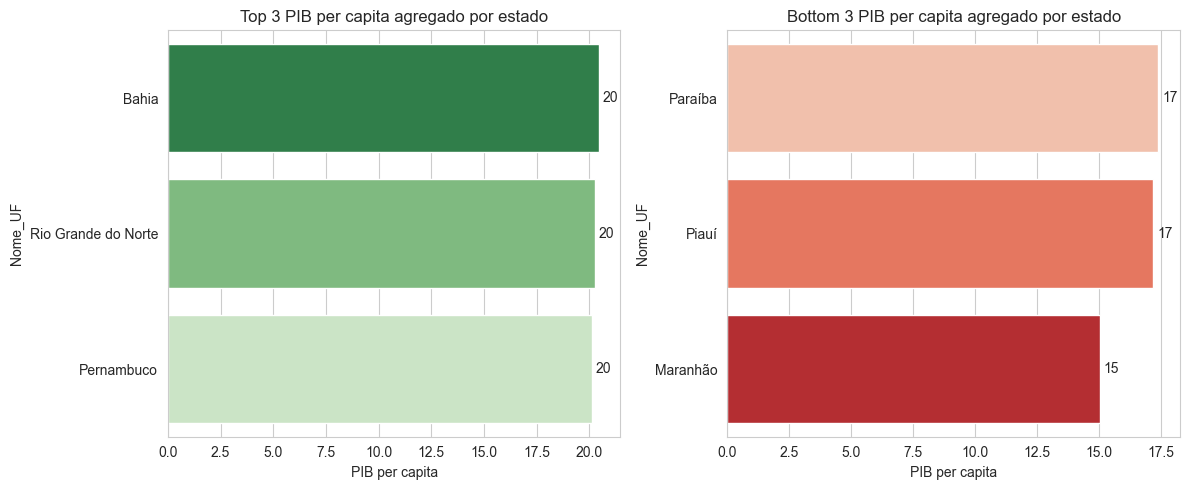

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Top 3
ax1 = sns.barplot(ax=axes[0], x='PIB per capita (UF)', y='Nome_UF', data=top3, palette='Greens_r')
axes[0].set_title('Top 3 PIB per capita agregado por estado')
axes[0].set_xlabel('PIB per capita')

# Adiciona labels com valores nas barras
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f', padding=3)  # sem casas decimais, com espaçamento

# Bottom 3
ax2 = sns.barplot(ax=axes[1], x='PIB per capita (UF)', y='Nome_UF', data=bottom3, palette='Reds')
axes[1].set_title('Bottom 3 PIB per capita agregado por estado')
axes[1].set_xlabel('PIB per capita')

for container in ax2.containers:
    ax2.bar_label(container, fmt='%.0f', padding=3)

plt.tight_layout()
plt.show()


In [ ]:
#minicipio
df_ordenado_1 = df_nordeste.sort_values(by='PIB per capita', ascending=False)
top5 = df_ordenado_1.head(5)
top5

In [ ]:
bottom5 = df_ordenado_1.tail(5)
bottom5

In [ ]:
filtro_top3 = df_nordeste[df_nordeste['Nome_UF'].isin(['Bahia','Rio Grande do Norte','Pernambuco'])]
filtro_ba = df_nordeste[df_nordeste['Nome_UF'].isin(['Bahia'])]
filtro_rn = df_nordeste[df_nordeste['Nome_UF'].isin(['Rio Grande do Norte'])]
filtro_pe = df_nordeste[df_nordeste['Nome_UF'].isin(['Pernambuco'])]


In [ ]:
# Lista dos estados no filtro
estados = ['Bahia', 'Rio Grande do Norte', 'Pernambuco']

for estado in estados:
    dados_estado = df_nordeste[df_nordeste['Nome_UF'] == estado]['PIB per capita']

    # Medidas de tendência central
    media = dados_estado.mean()
    mediana = dados_estado.median()
    moda = dados_estado.mode()[0] if not dados_estado.mode().empty else None

    # Medidas de dispersão
    desvio_padrao = dados_estado.std()
    variancia = dados_estado.var()
    amplitude = dados_estado.max() - dados_estado.min()
    q1 = dados_estado.quantile(0.25)
    q3 = dados_estado.quantile(0.75)
    coef_variacao = (desvio_padrao / media) * 100 if media != 0 else None
    iqr = q3 - q1

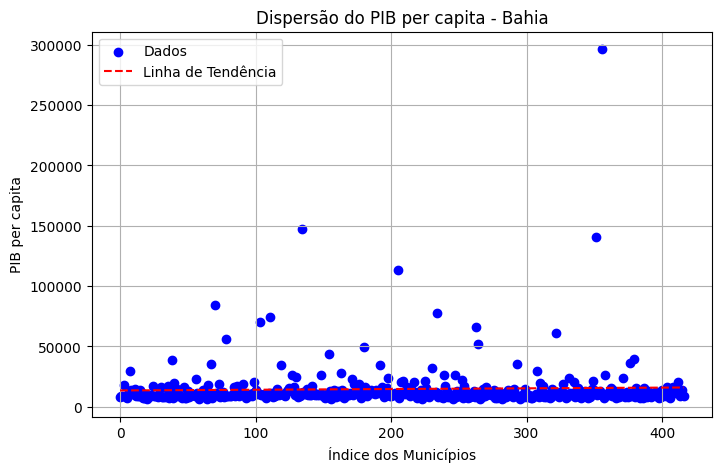

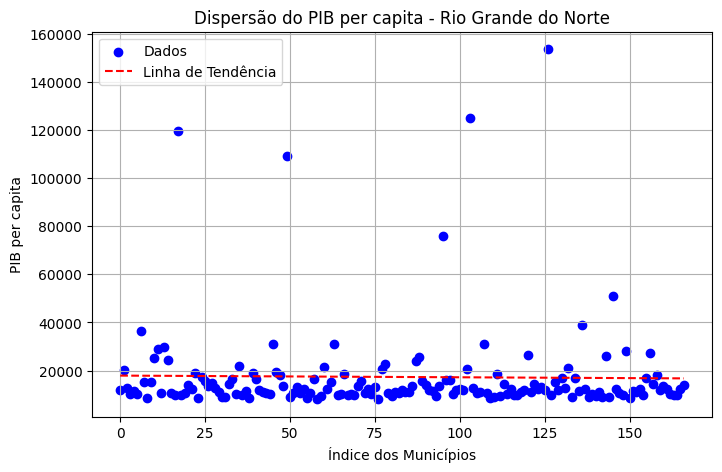

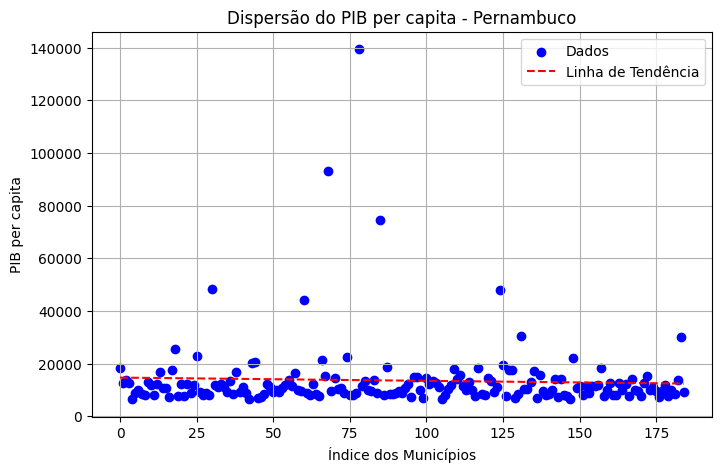

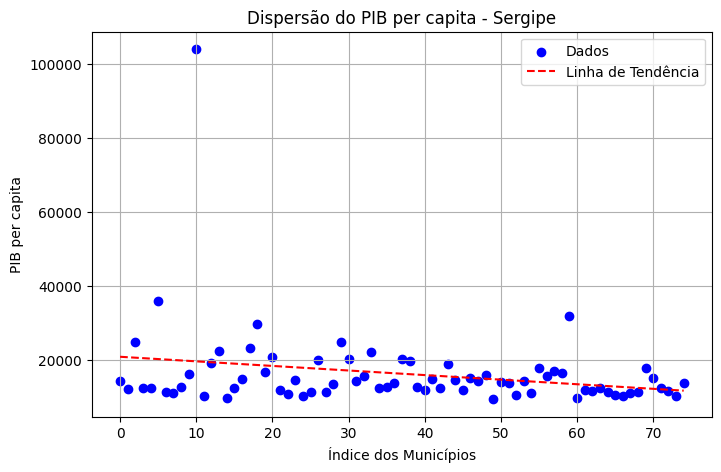

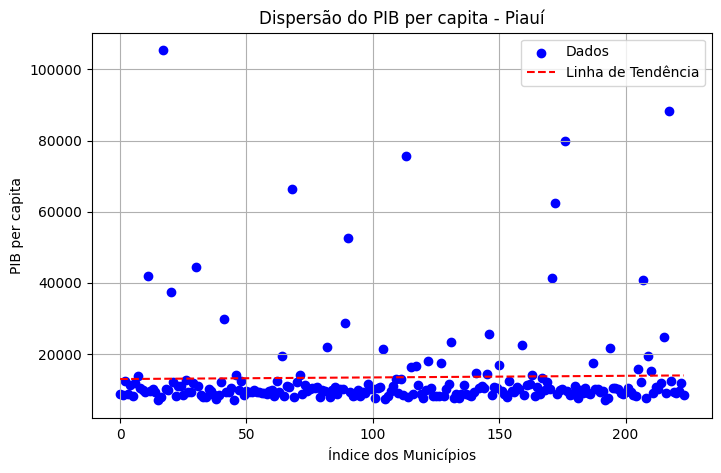

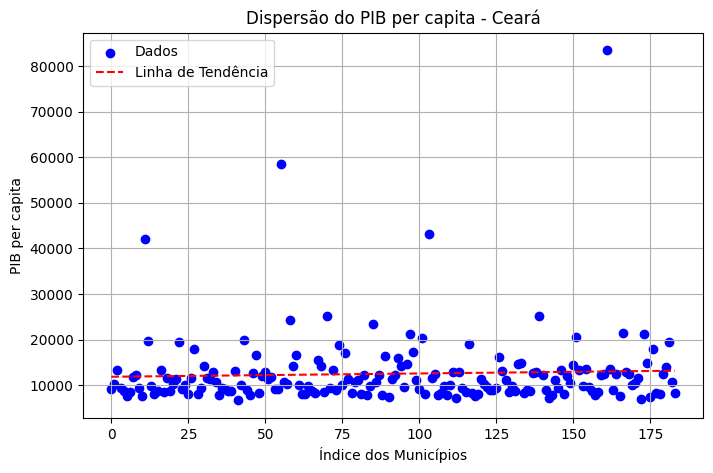

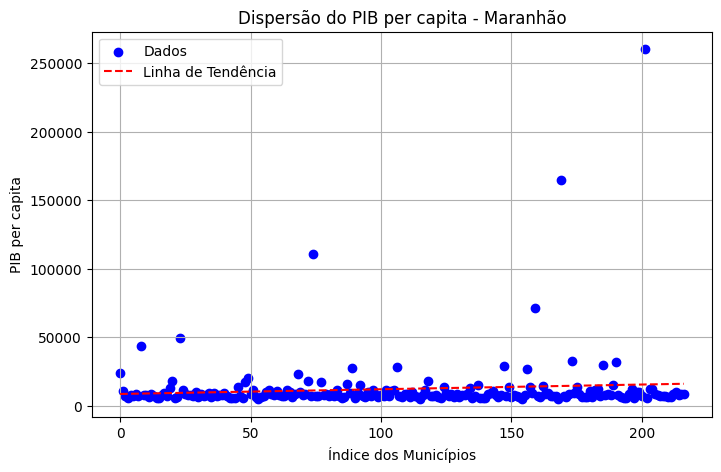

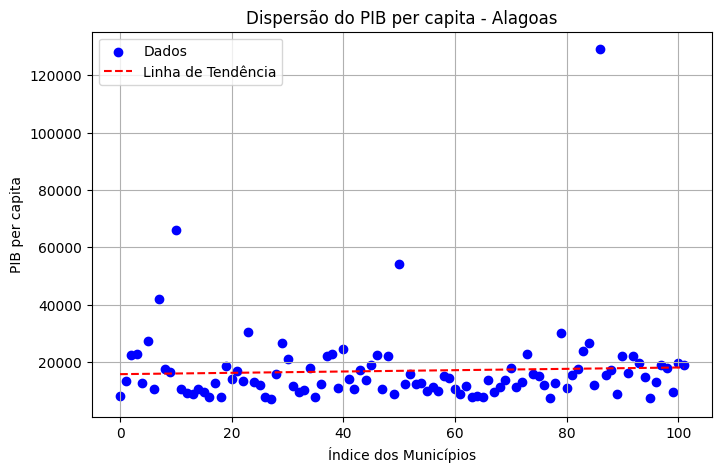

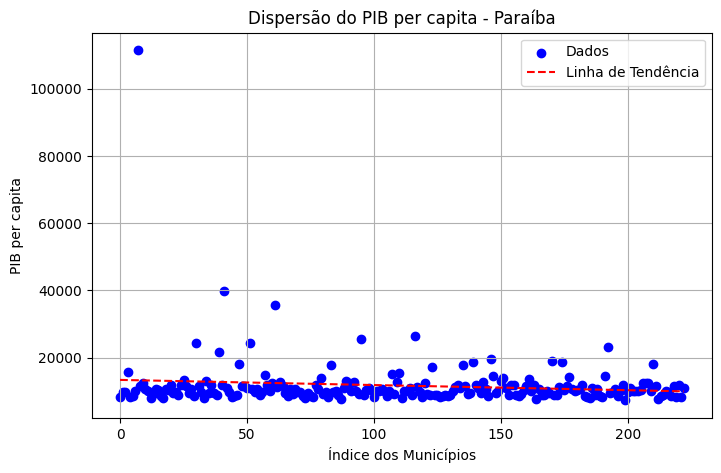

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Lista de estados para gerar os gráficos
estados = ['Bahia', 'Rio Grande do Norte', 'Pernambuco', 'Sergipe', 'Piauí', 'Ceará', 'Maranhão', 'Alagoas', 'Paraíba']

for estado in estados:
    dados_estado = df_nordeste[df_nordeste['Nome_UF'] == estado]

    # Preparando os dados
    x = np.arange(len(dados_estado))  # contagem de municípios do estado
    y = dados_estado['PIB per capita']

    # Criando a regressão linear para linha de tendência
    coef = np.polyfit(x, y, 1)  # grau 1 = linha
    poly1d_fn = np.poly1d(coef)

    # Criando o gráfico
    plt.figure(figsize=(8,5))
    plt.scatter(x, y, color='blue', label='Dados')
    plt.plot(x, poly1d_fn(x), color='red', linestyle='--', label='Linha de Tendência')

    # Labels
    plt.title(f'Dispersão do PIB per capita - {estado}')
    plt.xlabel('Índice dos Municípios')
    plt.ylabel('PIB per capita')
    plt.legend()
    plt.grid(True)
    plt.show()

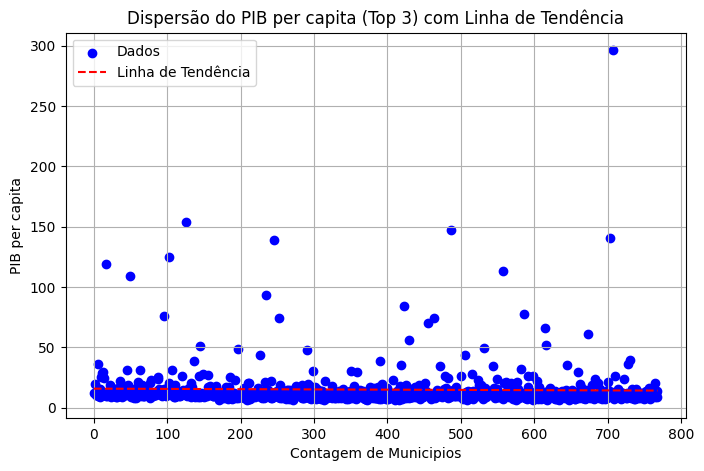

In [ ]:
import numpy as np
# Preparando os dados
x = np.arange(len(filtro_top3))  # contagem de municipios dentro do top3
y = filtro_top3['PIB per capita']

# Criando a regressão linear para linha de tendência
coef = np.polyfit(x, y, 1)  # grau 1 = linha
poly1d_fn = np.poly1d(coef)

# Plotando o gráfico de dispersão
plt.figure(figsize=(8,5))
plt.scatter(x, y, color='blue', label='Dados')

# Linha de tendência
plt.plot(x, poly1d_fn(x), color='red', linestyle='--', label='Linha de Tendência')

# Labels
plt.title('Dispersão do PIB per capita (Top 3) com Linha de Tendência')
plt.xlabel('Contagem de Municipios')
plt.ylabel('PIB per capita')
plt.legend()
plt.grid(True)
plt.show()

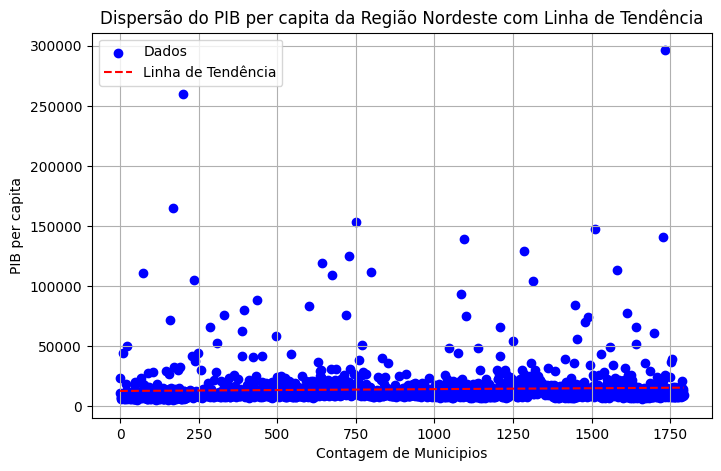

In [ ]:
import numpy as np
# Preparando os dados
x = np.arange(len(df_nordeste['Município_x']))  # contagem de municipios dentro do top3
y = df_nordeste['PIB per capita']

# Criando a regressão linear para linha de tendência
coef = np.polyfit(x, y, 1)  # grau 1 = linha
poly1d_fn = np.poly1d(coef)

# Plotando o gráfico de dispersão
plt.figure(figsize=(8,5))
plt.scatter(x, y, color='blue', label='Dados')

# Linha de tendência
plt.plot(x, poly1d_fn(x), color='red', linestyle='--', label='Linha de Tendência')

# Labels
plt.title('Dispersão do PIB per capita da Região Nordeste com Linha de Tendência')
plt.xlabel('Contagem de Municipios')
plt.ylabel('PIB per capita')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/gw/38t0m3710p57vxqjw00sb8q00000gn/T/ipykernel_92906/1607608870.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='PIB per capita', y='Município_x', data=top5, palette='Greens_r')


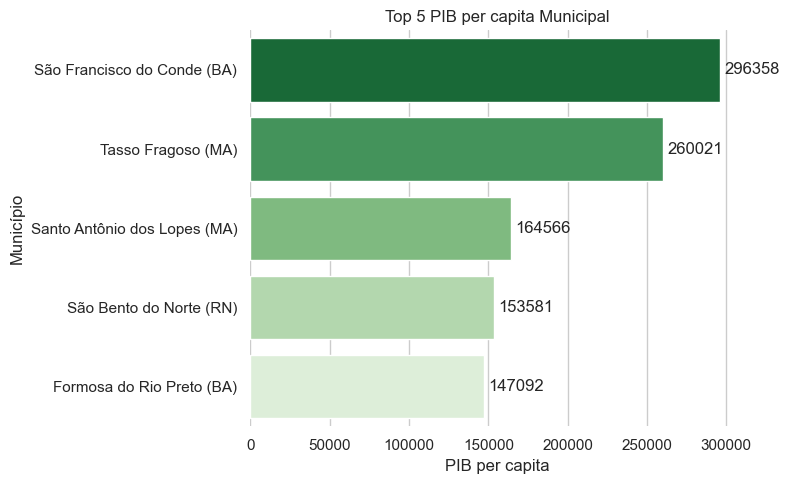

In [273]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.set_style("whitegrid")

ax = sns.barplot(x='PIB per capita', y='Município_x', data=top5, palette='Greens_r')
ax.set_title('Top 5 PIB per capita Municipal')
ax.set_xlabel('PIB per capita')
ax.set_ylabel('Município')

# Adiciona os valores na barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


/var/folders/gw/38t0m3710p57vxqjw00sb8q00000gn/T/ipykernel_92906/76440574.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='PIB per capita', y='Município_x', data=bottom5, palette='Reds')


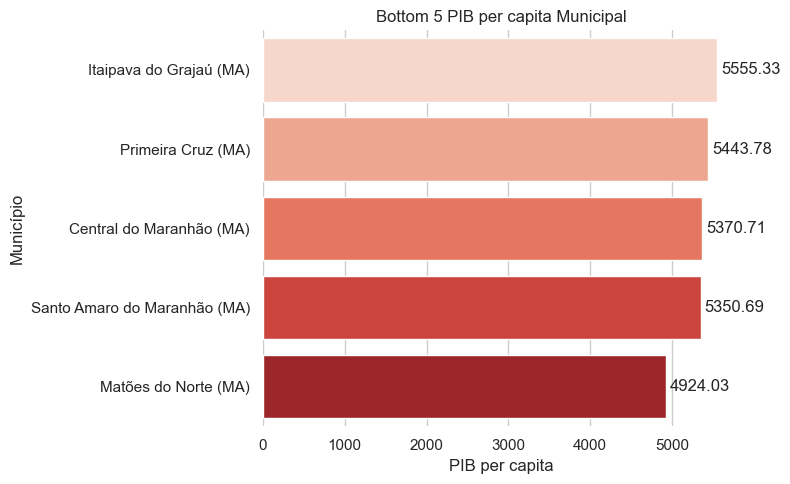

In [274]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.set_style("whitegrid")

ax = sns.barplot(x='PIB per capita', y='Município_x', data=bottom5, palette='Reds')
ax.set_title('Bottom 5 PIB per capita Municipal')
ax.set_xlabel('PIB per capita')
ax.set_ylabel('Município')

# Adiciona os valores na barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


In [ ]:
df_ordenado_2 = df_nordeste.sort_values(by='PIB (Mil Reais)', ascending=False)
df_ordenado_2

,Cód.,Município_x,PIB (Mil Reais),Impostos (Mil Reais),VA da agropecuária (Mil Reais),VA da indústria (Mil Reais),VA dos serviços (Mil Reais),VA da administração pública (Mil Reais),População (Pessoas),UF,...,Nome Região Geográfica Intermediária,Região Geográfica Imediata,Nome Região Geográfica Imediata,Mesorregião Geográfica,Nome_Mesorregião,Microrregião Geográfica,Nome_Microrregião,Município,Nome_Município,PIB per capita
949,2304400,Fortaleza (CE),65160893.0,9511525.0,107783.0,7651172.0,38074102.0,9816312.0,2686612.0,23,...,Fortaleza,230001,Fortaleza,3,Metropolitana de Fortaleza,16,Fortaleza,4400,Fortaleza,24253.927623
2162,2927408,Salvador (BA),58938115.0,8171919.0,54334.0,6493118.0,35251370.0,8967373.0,2886698.0,29,...,Salvador,290001,Salvador,5,Metropolitana de Salvador,21,Salvador,27408,Salvador,20417.139237
1596,2611606,Recife (PE),50311002.0,8854494.0,57630.0,5721619.0,28435779.0,7241480.0,1653461.0,26,...,Recife,260001,Recife,5,Metropolitana de Recife,17,Recife,11606,Recife,30427.691975
635,2111300,São Luís (MA),33074010.0,6599412.0,23674.0,7198257.0,15467449.0,3785218.0,1108975.0,21,...,São Luís,210001,São Luís,1,Norte Maranhense,2,Aglomeração Urbana de São Luís,11300,São Luís,29823.945535
1897,2905701,Camaçari (BA),25697266.0,6390141.0,17891.0,10382610.0,7528249.0,1378375.0,304302.0,29,...,Salvador,290001,Salvador,5,Metropolitana de Salvador,21,Salvador,5701,Camaçari,84446.589244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,2501153,Areia de Baraúnas (PB),22128.0,1047.0,982.0,893.0,3735.0,15472.0,2116.0,25,...,Patos,250009,Patos,1,Sertão Paraibano,4,Patos,1153,Areia de Baraúnas,10457.466919
794,2206308,Miguel Leão (PI),21627.0,1454.0,614.0,2042.0,5336.0,12181.0,1242.0,22,...,Teresina,220002,Amarante - Água Branca - Regeneração,2,Centro-Norte Piauiense,3,Teresina,6308,Miguel Leão,17413.043478
1240,2414902,Viçosa (RN),21254.0,739.0,768.0,738.0,5355.0,13654.0,1725.0,24,...,Mossoró,240010,Pau dos Ferros,1,Oeste Potiguar,6,Pau dos Ferros,14902,Viçosa,12321.159420
1375,2510659,Parari (PB),20839.0,903.0,1888.0,769.0,4692.0,12587.0,1758.0,25,...,Campina Grande,250008,Sumé,2,Borborema,10,Cariri Ocidental,10659,Parari,11853.811149


/var/folders/gw/38t0m3710p57vxqjw00sb8q00000gn/T/ipykernel_92906/1587299148.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='PIB (Mil Reais)', y='Município_x', data=df_ordenado_2.head(5), palette='Greens_r')


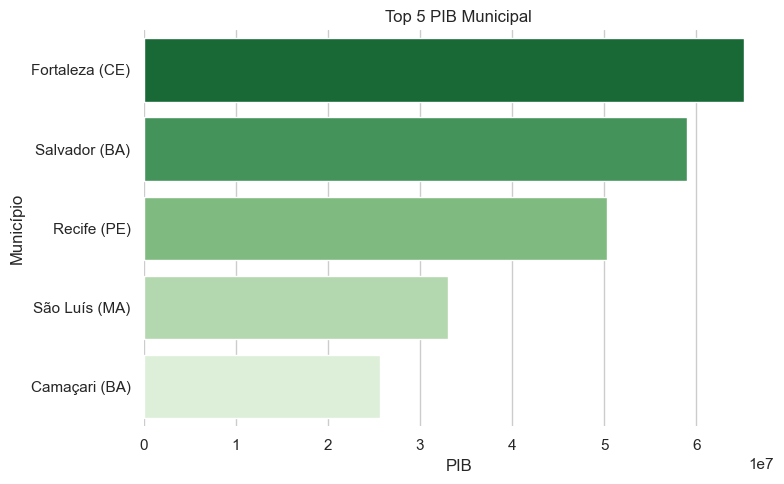

In [275]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.set_style("whitegrid")  # estilo mais clean, com grid suave

# Gráfico Top 5
ax = sns.barplot(x='PIB (Mil Reais)', y='Município_x', data=df_ordenado_2.head(5), palette='Greens_r')
ax.set_title('Top 5 PIB Municipal')
ax.set_xlabel('PIB')
ax.set_ylabel('Município')

# Remove bordas (spines)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


/var/folders/gw/38t0m3710p57vxqjw00sb8q00000gn/T/ipykernel_92906/1884532643.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='PIB (Mil Reais)', y='Município_x', data=df_ordenado_2.tail(5), palette='Reds')


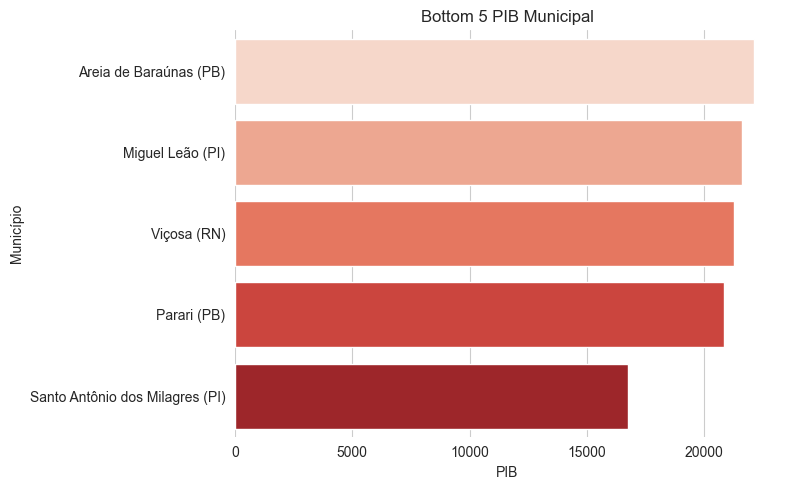

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.set_style("whitegrid")  # estilo mais clean, com grid suave

# Gráfico Top 5
ax = sns.barplot(x='PIB (Mil Reais)', y='Município_x', data=df_ordenado_2.tail(5), palette='Reds')
ax.set_title('Bottom 5 PIB Municipal')
ax.set_xlabel('PIB')
ax.set_ylabel('Município')

# Remove bordas (spines)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

/var/folders/gw/38t0m3710p57vxqjw00sb8q00000gn/T/ipykernel_92906/488982086.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='PIB (Mil Reais)', y='Município_x', data=top5, palette='Greens_r')


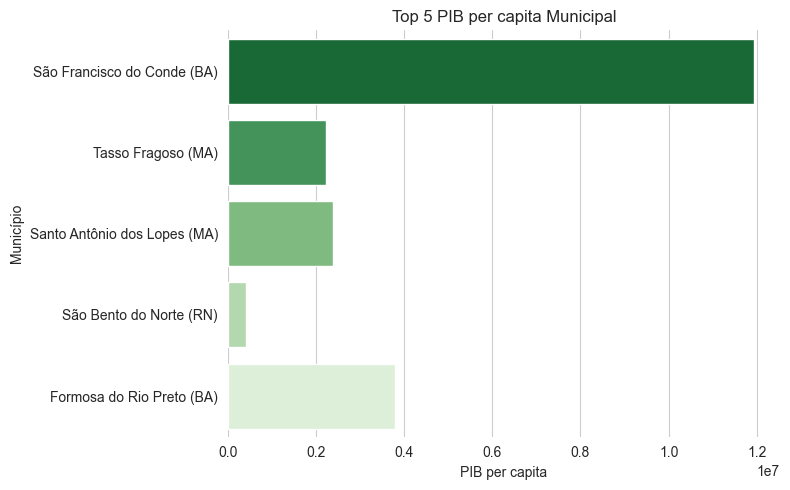

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.set_style("whitegrid")  # estilo mais clean, com grid suave

# Gráfico Top 5
ax = sns.barplot(x='PIB (Mil Reais)', y='Município_x', data=top5, palette='Greens_r')
ax.set_title('Top 5 PIB per capita Municipal')
ax.set_xlabel('PIB per capita')
ax.set_ylabel('Município')

# Remove bordas (spines)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

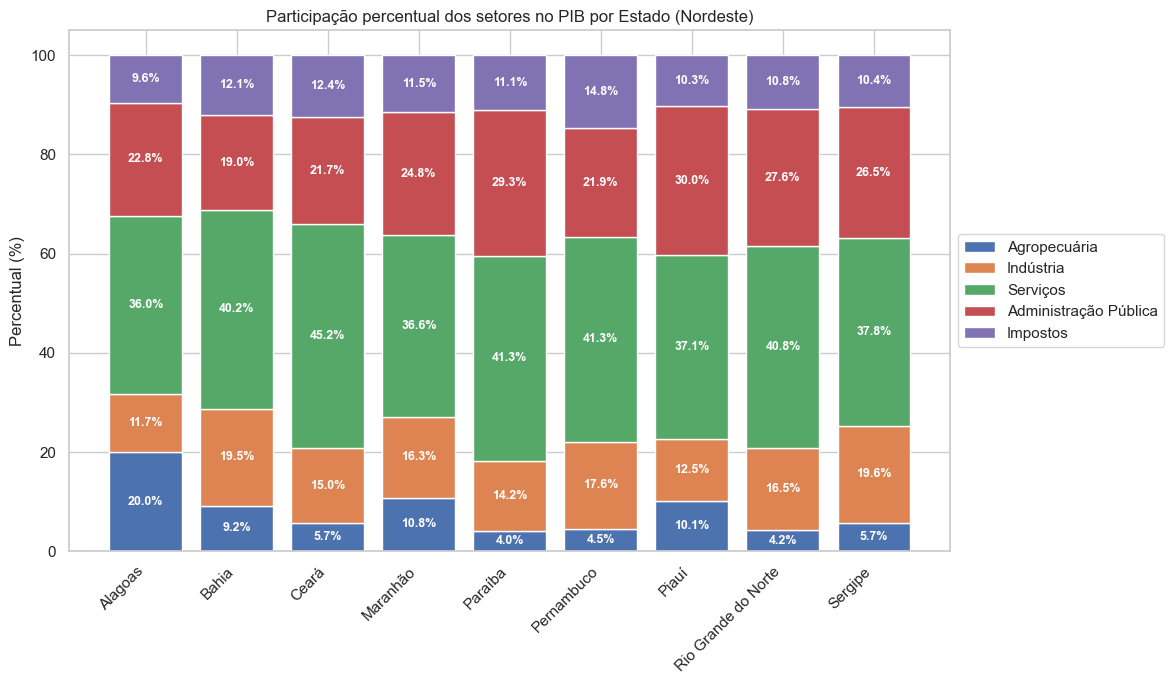

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

estados = df_uf_agrupado['Nome_UF']
pib = df_uf_agrupado['PIB (Mil Reais)']
impostos = df_uf_agrupado['Impostos (Mil Reais)']
agro = df_uf_agrupado['VA da agropecuária (Mil Reais)']
industria = df_uf_agrupado['VA da indústria (Mil Reais)']
servicos = df_uf_agrupado['VA dos serviços (Mil Reais)']
adm_publica = df_uf_agrupado['VA da administração pública (Mil Reais)']

total = pib.values

agro_pct = (agro / total) * 100
industria_pct = (industria / total) * 100
servicos_pct = (servicos / total) * 100
adm_publica_pct = (adm_publica / total) * 100
impostos_pct = (impostos / total) * 100

x = np.arange(len(estados))

fig, ax = plt.subplots(figsize=(14,7))

b1 = ax.bar(x, agro_pct, label='Agropecuária')
b2 = ax.bar(x, industria_pct, bottom=agro_pct, label='Indústria')
b3 = ax.bar(x, servicos_pct, bottom=agro_pct+industria_pct, label='Serviços')
b4 = ax.bar(x, adm_publica_pct, bottom=agro_pct+industria_pct+servicos_pct, label='Administração Pública')
b5 = ax.bar(x, impostos_pct, bottom=agro_pct+industria_pct+servicos_pct+adm_publica_pct, label='Impostos')

ax.set_xticks(x)
ax.set_xticklabels(estados, rotation=45, ha='right')
ax.set_ylabel('Percentual (%)')
ax.set_title('Participação percentual dos setores no PIB por Estado (Nordeste)')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def add_labels(barras):
    for barra in barras:
        altura = barra.get_height()
        if altura > 3:
            ax.text(barra.get_x() + barra.get_width()/2, barra.get_y() + altura/2,
                    f'{altura:.1f}%', ha='center', va='center', color='white', fontsize=9, fontweight='bold')

add_labels(b1)
add_labels(b2)
add_labels(b3)
add_labels(b4)
add_labels(b5)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [280]:
df_nordeste["PIB per capita"].skew()

np.float64(8.66433441335063)

**Assimetria** é uma medida de "inclinação" dos valores em relação a sua média.
**assimetria positiva:** indica que a causa está a direita

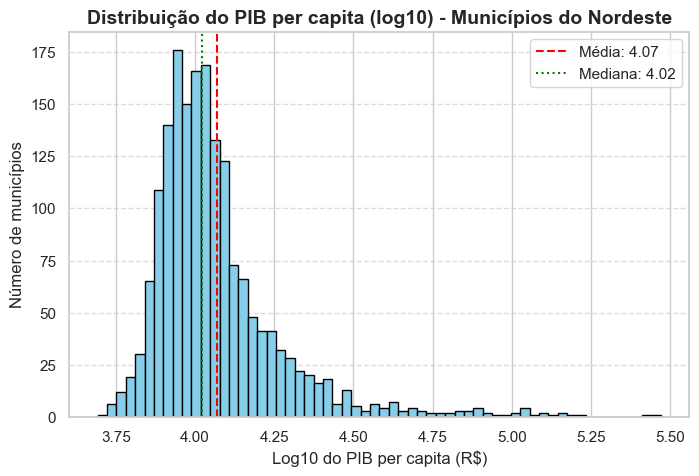

In [279]:
import matplotlib.pyplot as plt
import numpy as np

# Cria o histograma do PIB per capita (municípios do Nordeste) com log
plt.figure(figsize=(8,5))
plt.hist(np.log10(df_nordeste["PIB per capita"]), bins=60, color="skyblue", edgecolor="black")

# Títulos e rótulos ajustados
plt.title("Distribuição do PIB per capita (log10) - Municípios do Nordeste", fontsize=14, fontweight="bold")
plt.xlabel("Log10 do PIB per capita (R$)", fontsize=12)
plt.ylabel("Número de municípios", fontsize=12)

# Média e mediana no gráfico
media = np.mean(np.log10(df_nordeste["PIB per capita"]))
mediana = np.median(np.log10(df_nordeste["PIB per capita"]))
plt.axvline(media, color='red', linestyle='--', label=f"Média: {media:.2f}")
plt.axvline(mediana, color='green', linestyle=':', label=f"Mediana: {mediana:.2f}")

plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



````
Cada barra representa uma faixa de PIB per capita (em escala logarítmica).
O eixo Y mostra quantos municípios estão naquela faixa.
Ao usar o log10 do PIB per capita, nós transformamos valores que iam de alguns poucos reais por pessoa até centenas de milhares em uma escala mais compacta e interpretável.

Interpretação: A distribuição é fortemente assimétrica (cauda longa à direita). O log(10) suaviza essa assimetria, tornando o padrão mais claro.
Existem alguns poucos municípios com PIB per capita altíssimo (outliers).
A média é puxada para cima por esses outliers, ficando maior que a mediana.
````


In [281]:
df_nordeste["PIB per capita"].kurtosis()

np.float64(106.35798427831806)

In [282]:
df_nordeste["PIB (Mil Reais)"].kurtosis()

np.float64(263.30066599619386)

**Curtose**: Medida em relação a causa. 
Curtose elevada indica muitos outliers.

**Boxplot**: método gráfico para demonstrar localização, dispersão e asssimetria de dados numéricos.

/var/folders/gw/38t0m3710p57vxqjw00sb8q00000gn/T/ipykernel_92906/955373492.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="PIB per capita", data=df_nordeste, palette="Set2", whis=1.5)


<Axes: xlabel='PIB per capita'>

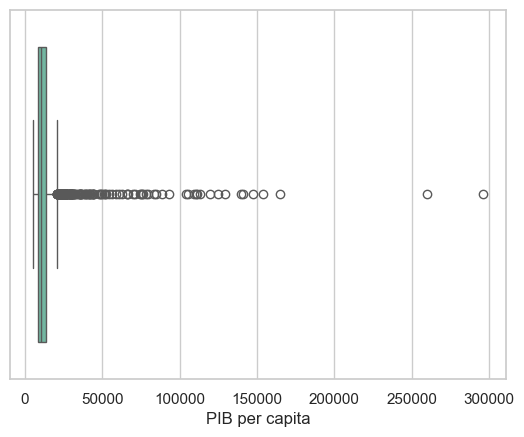

In [287]:
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.boxplot(x="PIB per capita", data=df_nordeste, palette="Set2", whis=1.5)



In [ ]:
q1=df_nordeste["PIB per capita"].quantile(0.25)
q3=df_nordeste["PIB per capita"].quantile(0.75)
m= df_nordeste["PIB per capita"].mean()
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr


/var/folders/gw/38t0m3710p57vxqjw00sb8q00000gn/T/ipykernel_92906/974687786.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="PIB (Mil Reais)", data=df_nordeste, palette="Set2", whis=0.5)


<Axes: xlabel='PIB (Mil Reais)'>

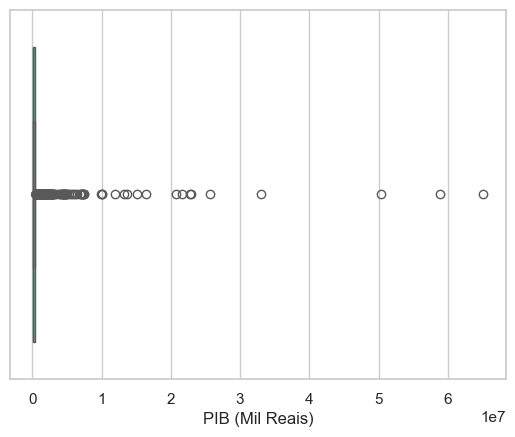

In [290]:
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.boxplot(x="PIB (Mil Reais)", data=df_nordeste, palette="Set2", whis=0.5)
